_Version log: Merging V17 and V15 but trying to (brute force) optimise one detector placement at a time._

In [43]:
import sys, warnings
from sklearn.linear_model import Lasso #I'm using scikit insted of svxpy to solve.
from sklearn.exceptions import ConvergenceWarning
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import scipy.ndimage as spimg
from scipy import optimize as spopt, fft as spfft
from PIL import Image #I prefer Pillow to imageio
from tqdm import tqdm
plt.rcParams.update({'font.size':16})
np.set_printoptions(threshold=sys.maxsize)

To turn a sparce signal $X$ into the full image $Y$. The L1 norm of,
\begin{equation}
    \mathcal{F} (Y),
\end{equation}
needs to be minimised while also minimising the L2 norm of,
\begin{equation}
    C \times \mathcal{F}^{-1} (I) \times \mathcal{F} (Y) - X,
\end{equation}
where $\mathcal{F}( )$ is the DCT, $I$ is an identerty matrix and $C$ is a cropping transformation matrix such that,
\begin{equation}
    C \times Y = X.
\end{equation}
The weighting between the first two equation can be changed using the regularisation coeffient, $\alpha$. Altogether, the function that needs to be minimised looks like,
\begin{equation}
    ||C \times \mathcal{F}^{-1} (I) \times \mathcal{F} (Y) - X||_{2} + \alpha ||\mathcal{F} (Y)||_{1},
\end{equation}
which can be re-writtern in terms of the measurement matrix $M$ and $\mathcal{F} (Y) = Y'$ as,
\begin{equation}
    ||M \times Y' - X||_{2} + \alpha ||Y'||_{1}.
\end{equation}

In [44]:
def open_compressed_dataset(file_name, file_type, compression):
    if file_type == ".csv":
        img = np.loadtxt("data\\" +file_name +file_type, delimiter=",")
        array = spimg.zoom(img, compression) # scipy ndimage.zoom compresses (or interpolates) an image.
    else:
        raise ValueError("{0:} is not a regonised file type.".format(file_type))
    return array, img

In [45]:
file_name = "1d_mock_interferogram"
file_type = ".csv"
compression = 0.2 #fraction of the dataset to keep

# original image
target, img = open_compressed_dataset(file_name, file_type, compression)
#target = target[200:801] #crop it
total_points = len(target)

In [46]:
regularization_coeffient = 1e-3 # DECREASE FOR COMPLEX IMAGES (up to 1e-7 (floating point error?)) INCREASE FOR SIMPLE IMAGES (up to 1e-2)

points = np.arange(total_points)
detectors = np.array([], dtype= np.int16)
best_residual = np.array([], dtype= np.int16)

for n in tqdm(points):
    score = np.full(total_points, np.nan, dtype= np.float64)

    for m in np.setdiff1d(points, detectors):
        test_points = np.append(detectors, m)

        signal_sparce = target[test_points]

        cropping_matrix = np.identity(total_points, dtype= np.float16)
        cropping_matrix = cropping_matrix[test_points] #cropping matrix operator
        dct_matrix = spfft.idct(np.identity(total_points), axis= 0)
        measurement_matrix = np.matmul(cropping_matrix, dct_matrix)

        lasso = Lasso(alpha=regularization_coeffient)
        try:
            with warnings.catch_warnings():
                warnings.filterwarnings("error", category= ConvergenceWarning) # I can't catch warnings. Make it into an error insted.
                lasso.fit(measurement_matrix, signal_sparce)
        except ConvergenceWarning as warning:
            lasso.coef_ = np.random.rand(total_points) # The event of poor convergence, take a guess!
            converged = False
        else:
            converged = True

        result_comp_L1 = lasso.coef_
        result_L1 = spfft.idct(result_comp_L1)
        residuals = target -result_L1
        score[m] = np.linalg.norm(residuals)

    detectors = np.append(detectors, np.nanargmin(score))
    
    if converged == True:
        best_residual = np.append(best_residual, np.nanmin(score))
    else:
        best_residual = np.append(best_residual, np.nan)

100%|██████████| 200/200 [00:48<00:00,  4.14it/s]


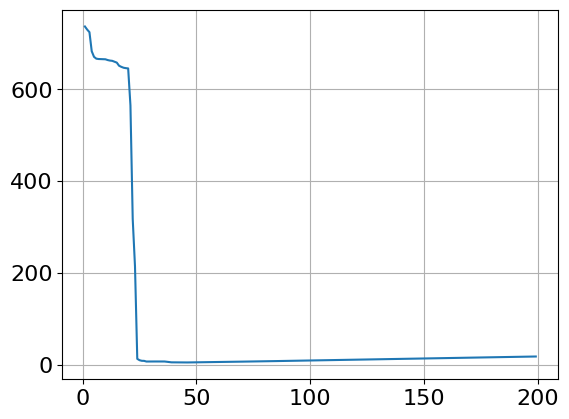

In [47]:
plt.plot(best_residual) # Shows the convergnce as more detectors are added. (Why does it go back up? Do steeper slopes corrispond with better detector positions?)
plt.grid(True)
plt.show()

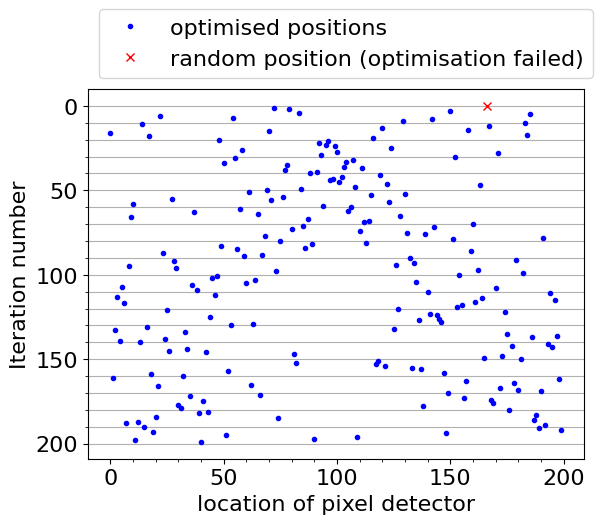

In [48]:
fig, ax = plt.subplots()

ax.plot(detectors[~np.isnan(best_residual)], np.arange(total_points)[~np.isnan(best_residual)], linestyle= "None", marker= ".", color= "b", label= "optimised positions")
ax.plot(detectors[np.isnan(best_residual)], np.arange(total_points)[np.isnan(best_residual)], linestyle= "None", marker= "x", color= "r", label= "random position (optimisation failed)")
ax.invert_yaxis() #better detector placements are at the top

ax.set(xlabel= "location of pixel detector", ylabel= "Iteration number")

ax.yaxis.get_ticklocs(minor= True)
ax.minorticks_on()

plt.legend(bbox_to_anchor= (0, 1.), loc= "lower left")
plt.grid(True, which= "both", axis= "y")
plt.show()

In [85]:
subsample_percentage = 0.125 #fraction of the dataset to subsample

reduced_points = round(total_points *subsample_percentage)
reduced_detectors = detectors[:reduced_points]

signal = np.full(total_points, np.nan)
signal[reduced_detectors] = target[reduced_detectors]
signal_sparce = target[reduced_detectors]

cropping_matrix = np.identity(total_points, dtype= np.float16)
cropping_matrix = cropping_matrix[reduced_detectors] #cropping matrix operator
dct_matrix = spfft.idct(np.identity(total_points), axis= 0)
measurement_matrix = np.matmul(cropping_matrix, dct_matrix)

lasso = Lasso(alpha=regularization_coeffient)
lasso.fit(measurement_matrix, signal_sparce)
result_comp_L1 = lasso.coef_

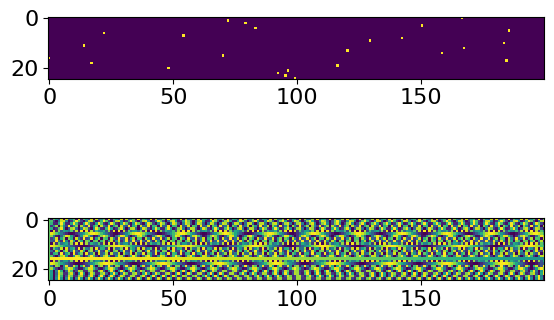

In [86]:
fig, axs = plt.subplots(2,1)

axs[0].imshow(cropping_matrix, interpolation= "nearest")
axs[1].imshow(measurement_matrix, interpolation= "nearest")

plt.show()

60.464084802139396


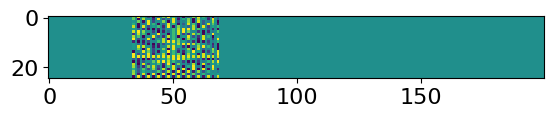

C:\Users\syf83691\AppData\Local\Temp\ipykernel_4544\1938124341.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  least_squares_result = np.linalg.lstsq(active_matrix, signal_sparce)


In [87]:
relative_activation_threshold = 1e-2 # WEAK COMPONENTS WILL NOT BE CONSIDERED FOR THE L2 SOLUTION
activation_threshold = relative_activation_threshold*np.nanmax(np.abs(result_comp_L1))

active_components = np.abs(result_comp_L1) >= activation_threshold
print(activation_threshold)

active_matrix = np.zeros_like(measurement_matrix)
active_matrix[:, active_components] = measurement_matrix[:, active_components]

plt.imshow(active_matrix, interpolation= "nearest")
plt.show()

result_comp_L2 = np.zeros_like(result_comp_L1)
least_squares_result = np.linalg.lstsq(active_matrix, signal_sparce)
result_comp_L2[active_components] = least_squares_result[0][active_components]

In [88]:
print(total_points)
print(reduced_points)

200
25


C:\Users\syf83691\AppData\Local\Temp\ipykernel_4544\27617983.py:3: RuntimeWarning: divide by zero encountered in divide
  result_L1_wavelengths= 1/ np.fft.rfftfreq(len(result_L1))
C:\Users\syf83691\AppData\Local\Temp\ipykernel_4544\27617983.py:6: RuntimeWarning: divide by zero encountered in divide
  target_wavelengths= 1/ np.fft.rfftfreq(len(target))


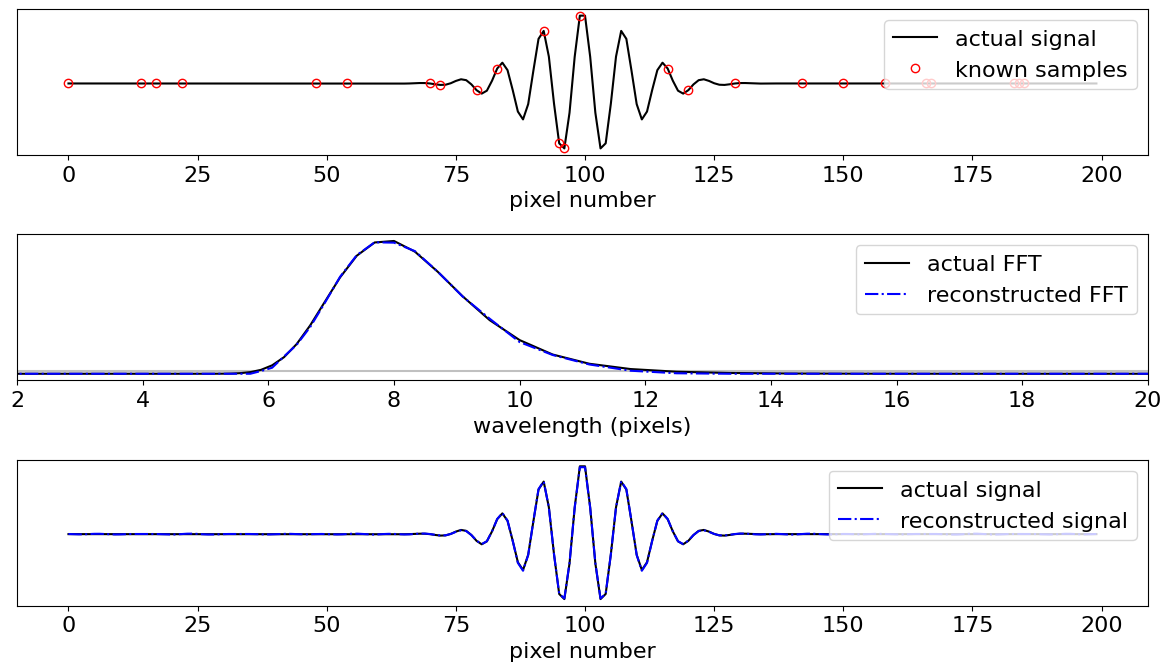

In [90]:
result_L1 = spfft.idct(result_comp_L1)
result_L1_FFT = np.abs(np.fft.rfft(result_L1))
result_L1_wavelengths= 1/ np.fft.rfftfreq(len(result_L1))
target_DCT = spfft.dct(target)
target_FFT = np.abs(np.fft.rfft(target))
target_wavelengths= 1/ np.fft.rfftfreq(len(target))

niquist = 0.5/1 # pixels^-1
k = niquist *np.arange(total_points) /total_points


plt.rcParams.update({'font.size':16})
fig, axs = plt.subplots(3,1, figsize= (12,7))

axs[0].plot(target, color= "k", label= "actual signal")
axs[0].plot(signal, marker= "o", markerfacecolor= "None", color= "red", linestyle= "None", label= "known samples")
axs[0].set(xlabel= "pixel number")
axs[1].hlines(activation_threshold, target_wavelengths.min(), 20, color= "silver")
axs[1].plot(target_wavelengths, target_FFT, color= "k", label= "actual FFT")
axs[1].plot(result_L1_wavelengths, result_L1_FFT, color= "blue", label= "reconstructed FFT", linestyle= "-.")
axs[1].set_xlim(target_wavelengths.min(),20)
axs[1].set(xlabel= "wavelength (pixels)")
axs[2].plot(target, color= "k", label= "actual signal")
axs[2].plot(result_L1, color= "blue", label= "reconstructed signal", linestyle= "-.")
axs[2].set(xlabel= "pixel number")

[ax.legend(loc= 'upper right') for ax in axs]
[ax.set(yticks= []) for ax in axs]

plt.tight_layout()
plt.show()

C:\Users\syf83691\AppData\Local\Temp\ipykernel_4544\2535218800.py:3: RuntimeWarning: divide by zero encountered in divide
  result_L1_wavelengths= 1/ np.fft.rfftfreq(len(result_L1))
C:\Users\syf83691\AppData\Local\Temp\ipykernel_4544\2535218800.py:6: RuntimeWarning: divide by zero encountered in divide
  target_wavelengths= 1/ np.fft.rfftfreq(len(target))
C:\Users\syf83691\AppData\Local\Temp\ipykernel_4544\2535218800.py:9: RuntimeWarning: divide by zero encountered in divide
  result_L2_wavelengths= 1/ np.fft.rfftfreq(len(result_L2))


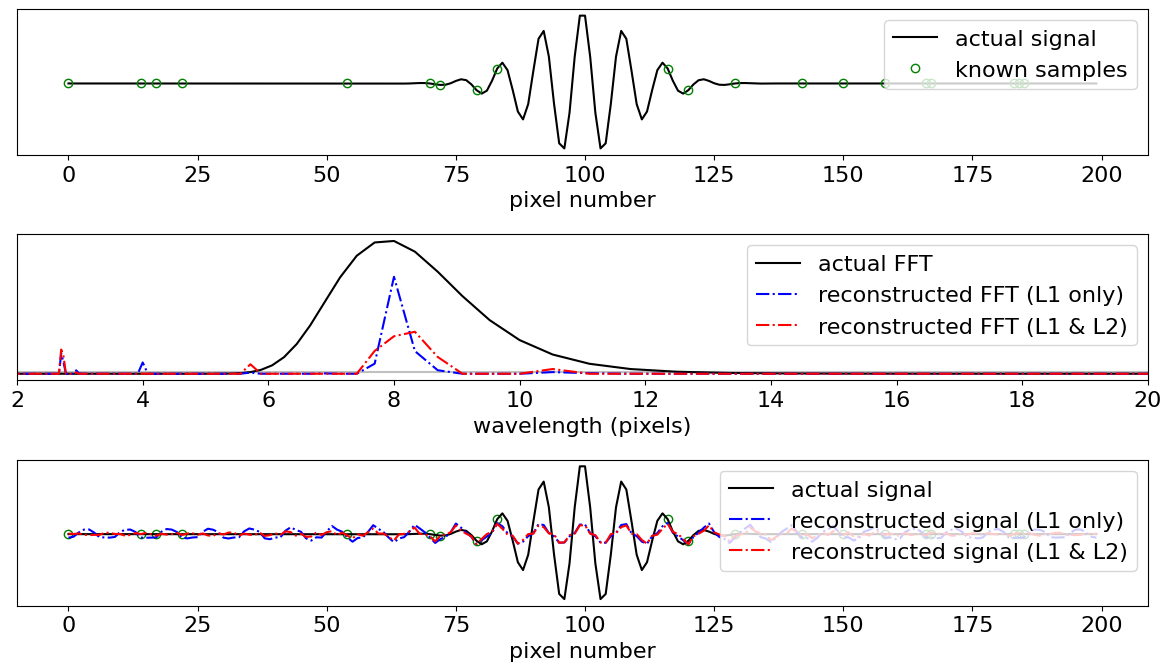

In [53]:
result_L1 = spfft.idct(result_comp_L1)
result_L1_FFT = np.abs(np.fft.rfft(result_L1))
result_L1_wavelengths= 1/ np.fft.rfftfreq(len(result_L1))
target_DCT = spfft.dct(target)
target_FFT = np.abs(np.fft.rfft(target))
target_wavelengths= 1/ np.fft.rfftfreq(len(target))
result_L2 = spfft.idct(result_comp_L2)
result_L2_FFT = np.abs(np.fft.rfft(result_L2))
result_L2_wavelengths= 1/ np.fft.rfftfreq(len(result_L2))

niquist = 0.5/1 # pixels^-1
k = niquist *np.arange(total_points) /total_points


plt.rcParams.update({'font.size':16})
fig, axs = plt.subplots(3,1, figsize= (12,7))

axs[0].plot(target, color= "k", label= "actual signal")
axs[0].plot(signal, marker= "o", markerfacecolor= "None", color= "green", linestyle= "None", label= "known samples")
axs[0].set(xlabel= "pixel number")
axs[1].hlines(activation_threshold, target_wavelengths.min(), 20, color= "silver")
axs[1].plot(target_wavelengths, target_FFT, color= "k", label= "actual FFT")
axs[1].plot(result_L1_wavelengths, result_L1_FFT, color= "blue", label= "reconstructed FFT (L1 only)", linestyle= "-.")
axs[1].plot(result_L2_wavelengths, result_L2_FFT, color= "red", label= "reconstructed FFT (L1 & L2)", linestyle= "-.")
axs[1].set_xlim(target_wavelengths.min(),20)
axs[1].set(xlabel= "wavelength (pixels)")
axs[2].plot(signal, marker= "o", markerfacecolor= "None", color= "green", linestyle= "None")
axs[2].plot(target, color= "k", label= "actual signal")
axs[2].plot(result_L1, color= "blue", label= "reconstructed signal (L1 only)", linestyle= "-.")
axs[2].plot(result_L2, color= "red", label= "reconstructed signal (L1 & L2)", linestyle= "-.")
axs[2].set(xlabel= "pixel number")

[ax.legend(loc= 'upper right') for ax in axs]
[ax.set(yticks= []) for ax in axs]

plt.tight_layout()
plt.show()